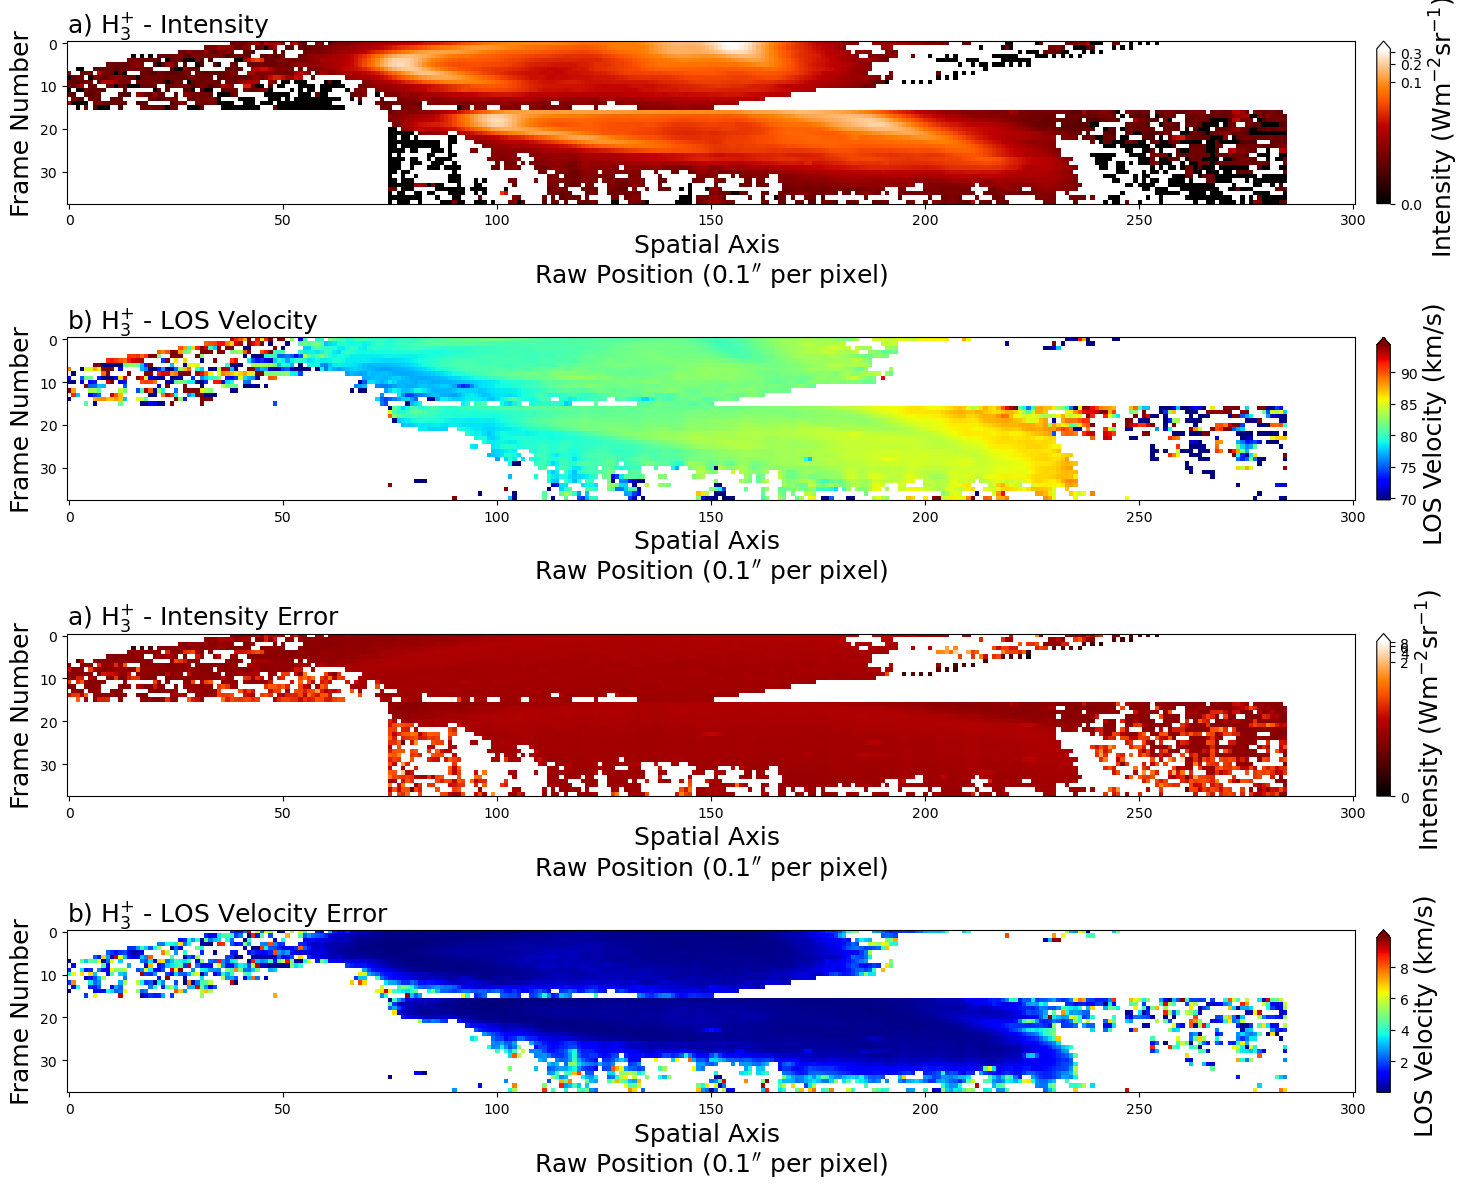

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from astropy.io import fits
from matplotlib.colors import PowerNorm, LogNorm
from lmfit import Model, fit_report
from lmfit.models import LinearModel

import os
spec_dir = os.path.abspath("./../spec/") + "/"
plots_dir = os.path.abspath("./../plots") + "/"

h3p_int_shifted = fits.open('h3p_int_shifted.fits', ignore_missing_end=True)[0].data
h3p_los_shifted = fits.open('h3p_los_shifted.fits', ignore_missing_end=True)[0].data
h3p_int_shifted_error = fits.open('h3p_int_shifted_error.fits', ignore_missing_end=True)[0].data
h3p_los_shifted_error = fits.open('h3p_los_shifted_error.fits', ignore_missing_end=True)[0].data

fig = plt.figure(figsize=(22,12), tight_layout=True)

fig.add_subplot(411)
plt.imshow(h3p_int_shifted, cmap='gist_heat', norm=PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(412)
plt.imshow(h3p_los_shifted, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_3^{+}$ - LOS Velocity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

fig.add_subplot(413)
plt.imshow(h3p_int_shifted_error, cmap='gist_heat', norm=PowerNorm(gamma=0.1))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - Intensity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(414)
plt.imshow(h3p_los_shifted_error, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_3^{+}$ - LOS Velocity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

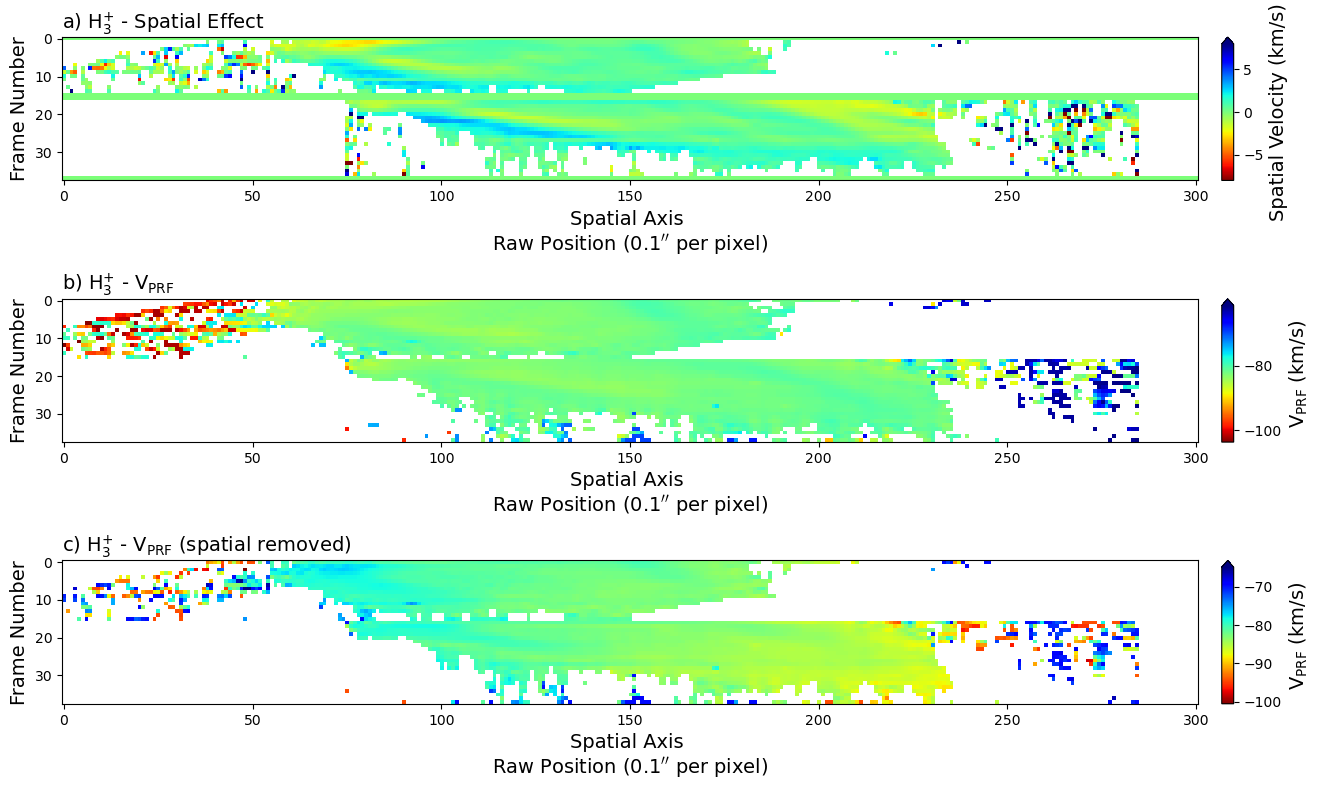

In [2]:
ang_diam = 40.58867 # arcseconds
# ang_diam/(0.1) slit unit = 0.1 arcsec/pixel
limb_vel = 12.572 # V_equator of Jupiter in km/s

vel_slope = limb_vel * 2 / (ang_diam/(0.1))

x = np.linspace(-150,150,301)
rot_rate = vel_slope * x
# rot_rate = rot_rate - rot_rate[150]

h3p_plan_vel = h3p_los_shifted + 0

for i in range(np.size(h3p_los_shifted, 0)):
    h3p_plan_vel[i,:] = h3p_los_shifted[i,:] - rot_rate


spatial_velocity = h3p_int_shifted + 0
spatial_velocity[::] = 0

for i in range(np.size(spatial_velocity, 1)):
    for j in range(1, np.size(spatial_velocity, 0)-1):
        if j not in (15,16):
            y = np.arange(3)
            p = np.array((h3p_int_shifted[j-1][i], h3p_int_shifted[j][i], h3p_int_shifted[j+1][i]))
#             print(j,i)
    #         plt.figure()
    #         plt.plot(y, p, 'k.', label='original')
            f = scipy.interpolate.interp1d(y,p)
            xnew = np.linspace(0,2,7)
    #         plt.figure()
    #         plt.plot(xnew, f(xnew), 'r.', label='interpolate')
    #         plt.legend()
    #         print(f(xnew[2]), f(xnew[4]))
            p1 = f(xnew[2])
            p3 = f(xnew[4])
            di = (p3 - p1)/(p3 + p1)
            dv = 7.99*di

            if np.isreal(dv):
                spatial_velocity[j,i] = dv

# h2_spat_vel2 = fits.open('h2_spatial_vel2.fits', ignore_missing_end=True)[0].data
# h2_plan_vel2 = fits.open('h2_plan_vel2.fits', ignore_missing_end=True)[0].data

# spatial_velocity2 = spatial_velocity + 0
# spatial_velocity2[np.isnan(h2_spat_vel2)] = np.nan
# spatial_velocity2[spatial_velocity <= 1.5] = np.nan

# h3p_plan_vel2 = h3p_plan_vel + 0
# h3p_plan_vel2[h3p_plan_vel2 > 5] = np.nan
# h3p_plan_vel2[h3p_plan_vel2 < -1] = np.nan
# h3p_plan_vel2[h3p_los_shifted_error > 1] = np.nan
# h3p_plan_vel2[np.isnan(h2_plan_vel2)] = np.nan

# spatial_velocity2[np.isnan(h3p_plan_vel2)] = np.nan

h3p_corrected_vel = h3p_los_shifted-spatial_velocity
# h3p_corrected_vel = h3p_plan_vel-spatial_velocity # use this for vprf

# h3p_corrected_vel[h3p_corrected_vel > 85] = 85
# h3p_corrected_vel[h3p_corrected_vel < 80] = 80

# h3p_plan_vel[h3p_plan_vel > 3] = 3
# h3p_plan_vel[h3p_plan_vel < -3] = -3


fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spatial_velocity*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('a) H$_3^{+}$ - Spatial Effect', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Spatial Velocity (km/s)',size=14)

fig.add_subplot(312)
plt.imshow(h3p_plan_vel*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('b) H$_3^{+}$ - V$_{\mathrm{PRF}}$', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

fig.add_subplot(313)
plt.imshow(h3p_corrected_vel*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('c) H$_3^{+}$ - V$_{\mathrm{PRF}}$ (spatial removed)', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

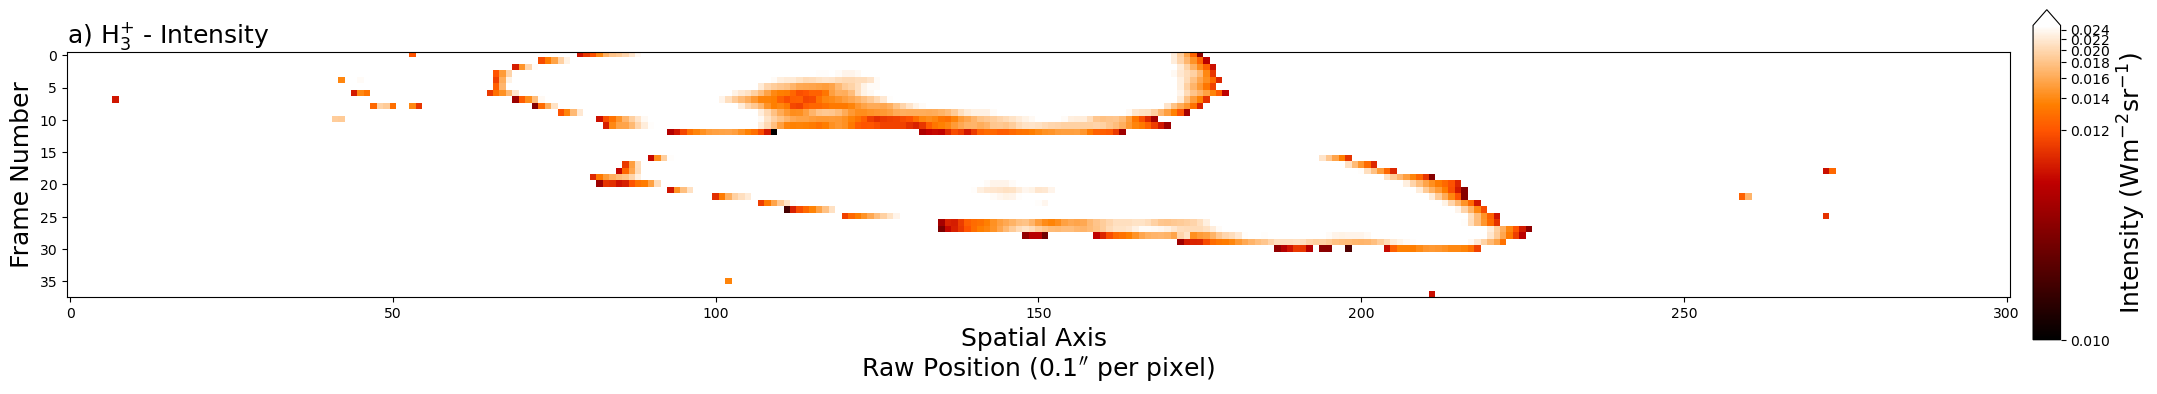

In [3]:
h3p_bright2 = h3p_int_shifted + 0
h3p_bright2[h3p_int_shifted > 0.025] = np.nan
h3p_bright2[h3p_int_shifted < 0.01] = np.nan
# h3p_bright2[3:11,100:150] = np.nan
# h3p_bright2[:16,245:] = np.nan

fig = plt.figure(figsize=(24,4), tight_layout=True)

fig.add_subplot(111)
plt.imshow(h3p_bright2, cmap='gist_heat', norm=PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

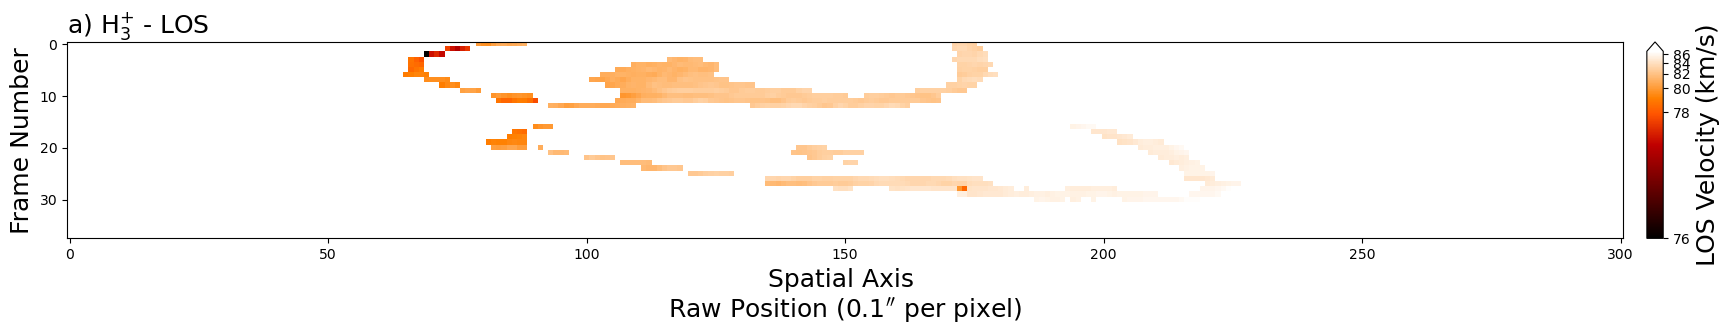

In [39]:
los_vel4 = h3p_corrected_vel + 0

los_vel4[np.isnan(h3p_bright2)] = np.nan

los_vel4[los_vel4 < 75] = np.nan
los_vel4[los_vel4 > 88] = np.nan

los_vel4[:,:60] = np.nan
# los_vel4[:,200:] = np.nan

# los_vel4[:16,:90] = np.nan
# los_vel4[:16,140:] = np.nan

# los_vel4[16:,:100] = np.nan


fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(313)
plt.imshow(los_vel4, cmap='gist_heat', norm=PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - LOS', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

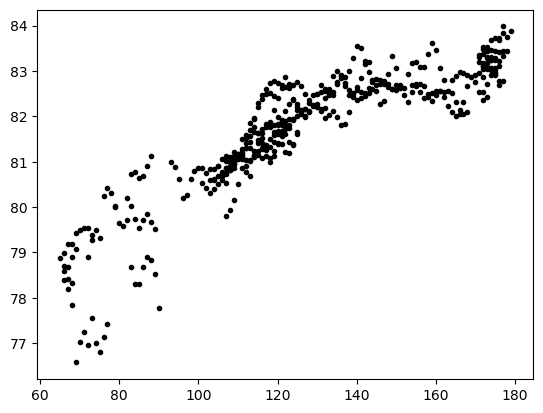

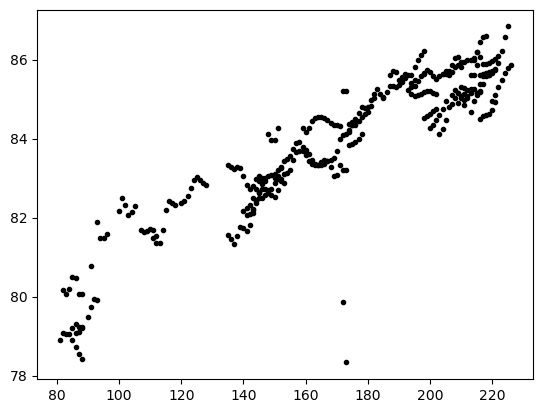

In [40]:
arr = los_vel4 + 0
for i in range(0,300):
    arr[:,i] = i
xt = arr[:16][np.isfinite(los_vel4[:16])]
vt = los_vel4[:16][np.isfinite(los_vel4[:16])]

xb = arr[16:][np.isfinite(los_vel4[16:])]
vb = los_vel4[16:][np.isfinite(los_vel4[16:])]

plt.figure()
plt.plot(xt,vt, 'k.')

plt.figure()
plt.plot(xb, vb, 'k.')

82.64496739195815
0.13526625046291174


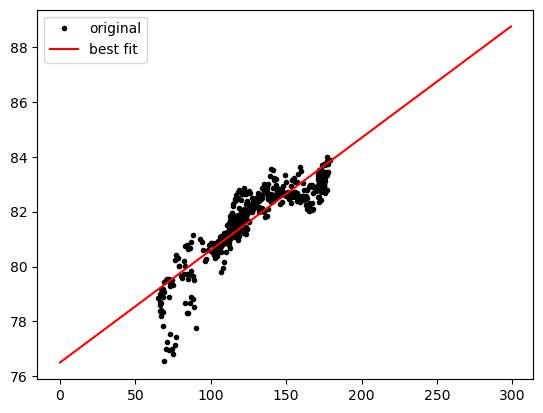

In [41]:
arr = los_vel4 + 0
for i in range(0,300):
    arr[:,i] = i
xt = arr[:16][np.isfinite(los_vel4[:16])]
vt = los_vel4[:16][np.isfinite(los_vel4[:16])]


mod = LinearModel()

pars = mod.guess(vt, x=xt)
out = mod.fit(vt, pars, x=xt)

mt = out.params['slope'].value
bt = out.params['intercept'].value
sig_mt = out.params['slope'].stderr
sig_bt = out.params['intercept'].stderr

# x_fit = np.linspace(110,219,110)
xtf = np.linspace(0,299,300)
vtf = mt * xtf + bt
vterr = np.sqrt(sig_mt**2 + sig_bt**2)

plt.figure()
plt.plot(xt, vt,'.k', label = 'original')
plt.plot(xtf, vtf, 'r', label = 'best fit')
# plt.vlines(50, ymin=77, ymax=90, color='b')
# plt.vlines(95, ymin=77, ymax=90, color='b')
# plt.vlines(140, ymin=77, ymax=90, color='y')
# plt.vlines(180, ymin=77, ymax=90, color='y')
# plt.hlines(87, xmin=0, xmax=300)
plt.legend()

print(vtf[np.where(xtf==150)][0])
print(vterr)

83.01467117615721
0.1657083296653834


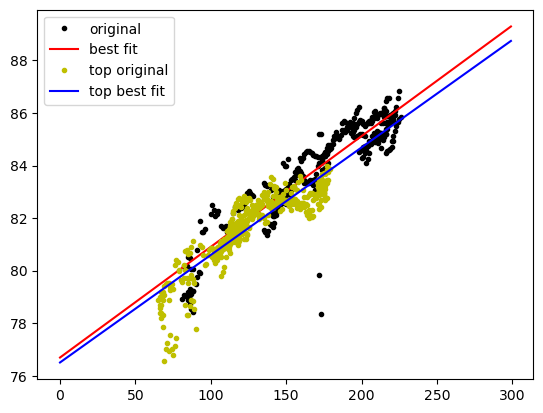

In [42]:
arr = los_vel4 + 0
for i in range(0,300):
    arr[:,i] = i
xb = arr[16:][np.isfinite(los_vel4[16:])]
vb = los_vel4[16:][np.isfinite(los_vel4[16:])]

mod = LinearModel()

pars = mod.guess(vb, x=xb)
out = mod.fit(vb, pars, x=xb)

mb = out.params['slope'].value
bb = out.params['intercept'].value
sig_mb = out.params['slope'].stderr
sig_bb = out.params['intercept'].stderr

# x_fit = np.linspace(110,219,110)
xbf = np.linspace(0,299,300)
vbf = mb * xbf + bb
vberr = np.sqrt(sig_mb**2 + sig_bb**2)

plt.figure()
plt.plot(xb, vb,'.k', label = 'original')
plt.plot(xbf, vbf, 'r', label = 'best fit')
plt.plot(xt, vt,'.y', label = 'top original')
plt.plot(xtf, vtf, 'b', label = 'top best fit')
# plt.ylim(80,90)
# plt.vlines(231, ymin=77, ymax=90, color='b')
# plt.vlines(89, ymin=77, ymax=90, color='b')
# plt.vlines(140, ymin=77, ymax=90, color='y')
# plt.vlines(180, ymin=77, ymax=90, color='y')
# plt.hlines(79, xmin=0, xmax=300)
plt.legend()

print(vbf[np.where(xbf==150)][0])
print(vberr)

In [43]:
vtf[np.where(xtf==150)][0] - vbf[np.where(xbf==150)][0]

-0.3697037841990607

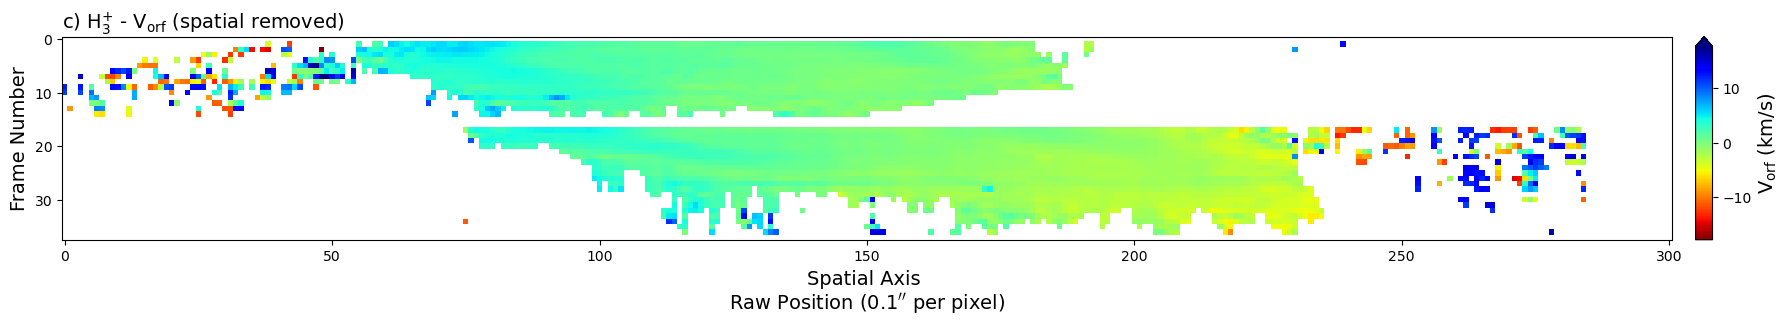

In [44]:
h3p_corrected_vel_sec1 = np.delete(h3p_corrected_vel, np.s_[16:], axis=0)
h3p_corrected_vel_sec2 = np.delete(h3p_corrected_vel, np.s_[:16], axis=0)

h3p_vorf_sec1 = h3p_corrected_vel_sec1 - vtf[np.where(xtf==150)][0]
h3p_vorf_sec2 = h3p_corrected_vel_sec2 - vbf[np.where(xbf==150)][0]

h3p_vorf = np.vstack((h3p_vorf_sec1, h3p_vorf_sec2))
# h3p_vorf[h3p_vorf > 1] = 1
# h3p_vorf[h3p_vorf < -3] = -3
h3p_vorf[0] = np.nan
h3p_vorf[15] = np.nan
h3p_vorf[16] = np.nan
h3p_vorf[-1] = np.nan
h3p_vorf[15:,:50] = np.nan


fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(313)
plt.imshow(h3p_vorf*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('c) H$_3^{+}$ - V$_{\mathrm{orf}}$ (spatial removed)', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{orf}}$ (km/s)',size=14)

In [45]:
h3p_los_shifted_error

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype='>f8')

In [46]:
h3p_los_shifted_error_sec1 = np.delete(h3p_los_shifted_error, np.s_[16:], axis=0)
h3p_los_shifted_error_sec2 = np.delete(h3p_los_shifted_error, np.s_[:16], axis=0)

In [47]:
vterr

0.13526625046291174

In [48]:
vberr

0.1657083296653834

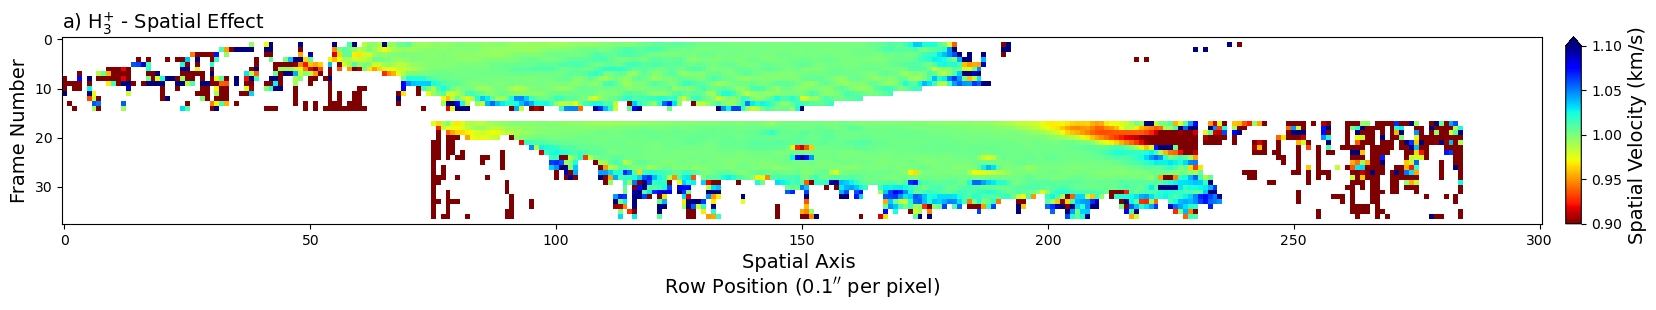

In [3]:
spatial_velocity2 = h3p_int_shifted * np.nan

b_err = 0.10641512039513978
# b_err = 0.09857723297462728

di1_arr = h3p_int_shifted * np.nan
di2_arr = h3p_int_shifted * np.nan
di_arr = h3p_int_shifted * np.nan

for i in range(np.size(spatial_velocity2, 1)):
# for i in range(1):
    for j in range(1, np.size(spatial_velocity2, 0)-1):
        if j not in (15,16):
            y = np.arange(3)
            a = h3p_int_shifted[j-1][i] - h3p_int_shifted_error[j-1][i]
            b = h3p_int_shifted[j][i]
            c = h3p_int_shifted[j+1][i] + h3p_int_shifted_error[j+1][i]
            p = np.array((a, b, c))
            d = h3p_int_shifted[j-1][i] + h3p_int_shifted_error[j-1][i]
            e = h3p_int_shifted[j][i]
            f = h3p_int_shifted[j+1][i] - h3p_int_shifted_error[j+1][i]
            q = np.array((d, e, f))
            l = h3p_int_shifted[j-1][i]
            m = h3p_int_shifted[j][i]
            n = h3p_int_shifted[j+1][i]
            r = np.array((l, m, n))
#             print(j,i)
#             plt.figure()
#             plt.plot(y, p, 'k', label='original')
            f1 = scipy.interpolate.interp1d(y,p)
            f2 = scipy.interpolate.interp1d(y,q)
            f = scipy.interpolate.interp1d(y,r)
            xnew = np.linspace(0,2,7)
#             plt.figure()
#             plt.plot(xnew, f(xnew), 'r.', label='interpolate')
    #         plt.legend()
#             print(f(xnew[2]), f(xnew[4]))
            p11 = f1(xnew[2])
            p31 = f1(xnew[4])
            p12 = f2(xnew[2])
            p32 = f2(xnew[4])
            p1 = f(xnew[2])
            p3 = f(xnew[4])
            di1 = (p31 - p11)/(p31 + p11)
            di2 = (p32 - p12)/(p32 + p12)
            di = (p3 - p1)/(p3 + p1)
            
#             di1_arr.append(di1)
#             di2_arr.append(di2)
#             di_arr.append(di)
            
#             print('di1 = '+str(di1))
#             print('di2 = '+str(di2))
            sig = (di1-di2)/2.
#             sig = np.nanmean(di1-di) + np.nanmean()
#             print('sig = '+str(sig))
            
            dv = 7.99*di
            dv_err = dv * np.sqrt((b_err/7.99)**2 + (sig/di)**2)
#             print('dv_err = '+str(dv_err))
#             print('dv = '+str(dv))
            if np.isreal(dv_err):
                spatial_velocity2[j,i] = dv_err
                di1_arr[j,i] = di1
                di2_arr[j,i] = di2
                di_arr[j,i] = di
# di1_arr = np.array(di1_arr)
# di2_arr = np.array(di2_arr)
# di_arr = np.array(di_arr)
# plt.figure()
# plt.plot(di1_arr-di_arr)
# plt.plot(di_arr - di2_arr)

fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow((di1_arr-di_arr)/(di_arr-di2_arr), vmin=0.9, vmax=1.1, cmap='jet_r')
plt.xlabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('a) H$_3^{+}$ - Spatial Effect', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Spatial Velocity (km/s)',size=14)

# fig.add_subplot(312)
# plt.imshow(di2_arr, cmap='jet_r')
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
# plt.ylabel('Frame Number', fontsize=14)
# plt.title('a) H$_3^{+}$ - Spatial Effect', loc='left', fontsize=14)

# fig.add_subplot(313)
# plt.imshow(di_arr, cmap='jet_r')
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
# plt.ylabel('Frame Number', fontsize=14)
# plt.title('a) H$_3^{+}$ - Spatial Effect', loc='left', fontsize=14)

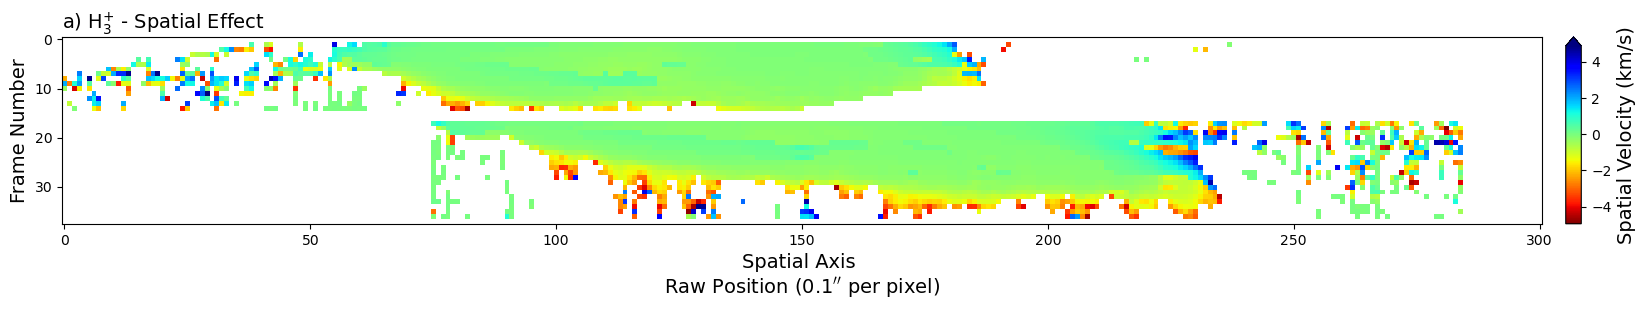

In [4]:
spatial_velocity2[spatial_velocity2 > 5] = np.nan
spatial_velocity2[spatial_velocity2 < -5] = np.nan

fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spatial_velocity2, cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('a) H$_3^{+}$ - Spatial Effect', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Spatial Velocity (km/s)',size=14)

In [5]:
np.nanmin(spatial_velocity2)

-4.949870337102004

In [8]:
spat_err = spatial_velocity2.copy()
spat_err

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [9]:
np.nanmin(spat_err)

-4.949870337102004

In [6]:
spat_err = fits.open('h3p_spat_err.fits', ignore_missing_end=True)[0].data
spat_err

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype='>f8')

In [7]:
np.nanmin(spat_err)

-4.949870337102004

In [50]:
spat_err_sec1 = np.delete(spat_err, np.s_[16:], axis=0)
spat_err_sec2 = np.delete(spat_err, np.s_[:16], axis=0)

In [51]:
h3p_tot_error_sec1 = np.sqrt((h3p_los_shifted_error_sec1)**2 + (vterr)**2 + (spat_err_sec1)**2)
h3p_tot_error_sec2 = np.sqrt((h3p_los_shifted_error_sec2)**2 + (vberr)**2 + (spat_err_sec2)**2)

h3p_tot_error = np.vstack((h3p_tot_error_sec1, h3p_tot_error_sec2))
h3p_tot_error

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

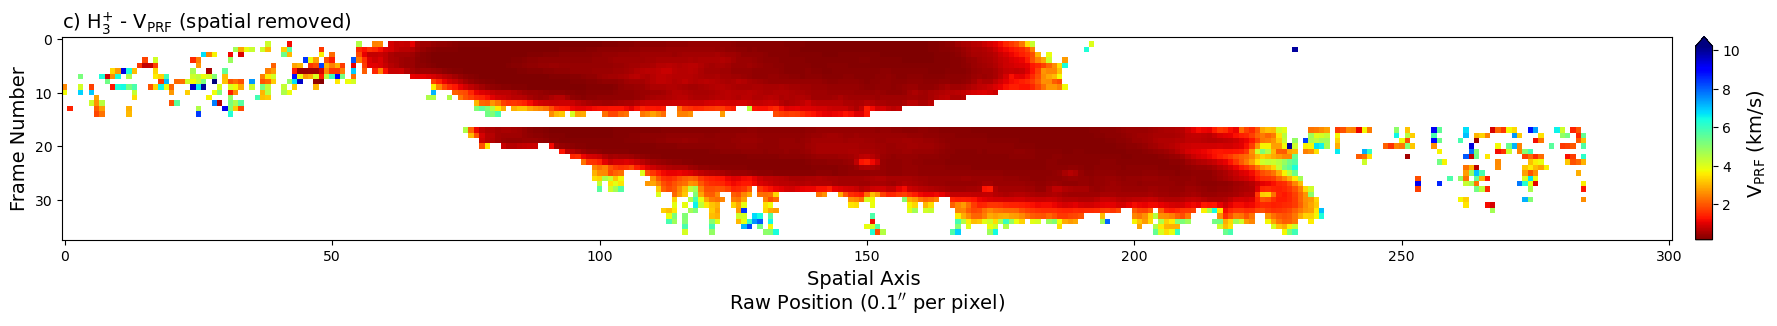

In [52]:
fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(313)
plt.imshow(h3p_tot_error, cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('c) H$_3^{+}$ - V$_{\mathrm{PRF}}$ (spatial removed)', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

In [53]:
hdu1 = fits.PrimaryHDU(h3p_vorf)
hdu1.writeto('h3p_vorf.fits', overwrite=True)

hdu2 = fits.PrimaryHDU(h3p_tot_error)
hdu2.writeto('h3p_vorf_err.fits', overwrite=True)